In [1]:
import sys
import numpy as np
import scipy.io
import torch
from pyDOE import lhs
from torch import Tensor, ones, stack, load
from torch.autograd import grad
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
from torch.nn import Module

sys.path.append('../NeuralSolvers')  # PINNFramework etc.
import PINNFramework as pf

Was not able to import Horovod. Thus Horovod support is not enabled


In [198]:
class InitialConditionDataset(Dataset):

    def __init__(self, n0):

        super(type(self)).__init__()
        data = pd.read_csv('2021-02-20_battHeater_outside_temp9.0C_IC4.66.csv')
        T = pd.DataFrame(data, columns= ['Temperature(℃)']).to_numpy()
        
        depth = 40 # in mm
        max_t = T.size*60 # in s
        
        # time-dependent temperature distribution at surface
        u = T
        t = np.arange(0,max_t,60).reshape((u.size, 1))
        #x = np.linspace(0, depth, num=200)
        #x = x.reshape((x.size,1))
        x = depth * np.ones_like(t)

        # initial temperature distribution
        x0 = np.linspace(0, depth, num=200).reshape(-1,1) # full depth of battery
        t0 = np.zeros_like(x0) # at t_0=0
        u0 = np.ones_like(x0) * 4.66 # °C, temperature distribution is in equilibrium 

        u = np.concatenate([u,u0])
        x = np.concatenate([x,x0])
        t = np.concatenate([t,t0])

        # select subset
        idx_x = np.random.choice(x.shape[0], n0, replace=False)
        self.x = x[idx_x,:]
        self.u = u[idx_x,:]
        self.t = t[idx_x,:]

    def __len__(self):
        """
        There exists no batch processing. So the size is 1
        """
        return 1

    def __getitem__(self, idx):
        x = np.concatenate([self.x, self.t], axis=1)
        y = np.concatenate([self.u], axis=1)

        return Tensor(x).float(), Tensor(y).float()

## Preprocessing
Thermal data was acquired by a sensor placed at the inner-most side of the battery pack. The Physics-informed Neural Network will be trained to interpolate this data right at the upper interface of the computational domain (i.e. x=1). The physics-based loss now allows us to recover the subsurface temperature distribution (i.e. x<1) by exploiting prior knowledge about the governing equation: heat equation with source term. The hidden physics model (HPM) is going to estimate all parameter of our model to explain the data.

In [199]:
data=pd.read_csv('2021-02-20_battHeater_outside_temp9.0C_IC4.66.csv')
u = pd.DataFrame(data, columns= ['Temperature(℃)']).to_numpy()
t = np.arange(0,u.size*60,60).reshape((u.size, 1))
x= np.linspace(0, 1, num=200)
x=x.reshape((x.size,1))

In [200]:
class PDEDataset(Dataset):
    def __init__(self, nf, lb, ub):
        self.xf = lb + (ub - lb) * lhs(2, nf)

    def __getitem__(self, idx):
        """
        Returns data for initial state
        """
        return Tensor(self.xf).float()

    def __len__(self):
        """
        There exists no batch processing. So the size is 1
        """
        return 1

This cell is returning all partial derivatives required for approximating the time derivative $u_t$ of our heat equation.

In [201]:
    def derivatives(x, u):
        u = u[:, 0]
        #print("x:", x.shape)
        grads = ones(u.shape, device=u.device) # move to the same device as prediction
        grad_u = grad(u, x, create_graph=True, grad_outputs=grads)[0]

        # calculate first order derivatives
        u_x = grad_u[:, 0]
        #print("u_x", u_x.shape)
        u_t = grad_u[:, 1]

        # calculate second order derivatives
        grad_u_x = grad(u_x, x, create_graph=True, grad_outputs=grads)[0]

        u_xx = grad_u_x[:, 0]
        #print("u_xx", u_xx.shape)

        x, t = x.T
        x = x.reshape(u.shape)
        t = t.reshape(u.shape)

        return torch.stack([x, t, u,
                        u_xx, u_t], 1).squeeze()

The **Hidden Physics Model** is used for recovering the spatially-dependent thermal diffusivity $\kappa$ as well as the heat rate and position of a heat source.

In [346]:
class HPM(Module):

    def __init__(self, kappa_net: Module):
        """
        Constructor of the HPM Model 
        """
        super(HPM, self).__init__()
        # spatially-dependent kappa
        #self.kappa_net = kappa_net
        # isotropic kappa
        self.kappa = (torch.tensor(0.05, requires_grad = False).cuda()) # make it nn.Parameter to optimize the parameter by ADAM
        
        self.heat_source_const = torch.tensor(1, requires_grad = False).cuda() # heat generation rate of heat source
        self.pos_heat_source = torch.tensor(25, requires_grad = False).cuda() # initialized at 5 mm
        self.width_heat_source = 4 # +/- width of heat source in  mm
  
    def forward(self, derivatives):
        x_coord = derivatives[:, 0].view(-1,1)
        t_coord = derivatives[:, 1].view(-1,1)
        
        # check for points in L2-ball of diameter 0.1 close to pos_heat_source
        heat_source_selector = (torch.where((x_coord - self.pos_heat_source)**2 < self.width_heat_source, 1, 0  )).view(-1) 

        # recover 2nd derivative in depth direction
        u_xx = derivatives[:, 3].view(-1)

        # predict spatially dependent kappas
        #kappa_output = self.kappa_net(x_coord)
        #kappa_output = kappa_output.view(-1)
        #predicted_u_t = kappa_output * (u_xx) + heat_source_selector * self.heat_source_const
        
        # assume isotropic kappa and just optimize scalar
        predicted_u_t = self.kappa * (u_xx) + heat_source_selector * self.heat_source_const

        return predicted_u_t


In [347]:
X = torch.from_numpy(np.linspace(0, 40, num=200).reshape(-1,1))
#kappa = hpm_model.kappa_net(X.cuda().float())
heat_source_selector = torch.where((X - 5)**2 < 1, 1, 0  ) 

In [348]:
for p in hpm_model.parameters():
    print(p)

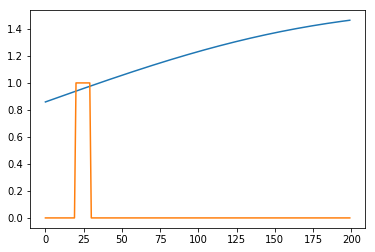

In [349]:
plt.plot(kappa.cpu().detach().numpy())
plt.plot(heat_source_selector.cpu().detach().numpy())

## Train Physics-informed Neural Network

This cell will be initialising all our models as well as setting the bounds of our computational domain.

In [350]:
# Domain bounds
lb = np.array([0.0, 0.0])
ub = np.array([40, 12600])

# initial condition
ic_dataset = InitialConditionDataset(n0=20)
initial_condition = pf.InitialCondition(ic_dataset)

pde_dataset = PDEDataset(2000, lb, ub)

# Diffusivity model
# Input: x
# Output: diffusivity k
kappa_net = pf.models.MLP(input_size=1,
                          output_size=1,
                          hidden_size=100,
                          num_hidden=4,
                          lb = lb[0:1] ,
                          ub = ub[0:1])

# PINN model
# Input: x,t
# Output: temperature u at the point
model = pf.models.MLP(input_size=2,
                      output_size=1, 
                      hidden_size=100, 
                      num_hidden=4, 
                      lb=lb, 
                      ub=ub)
kappa_net.cuda()
hpm_model = HPM(None) #used to be kappa_net

hpm_loss = pf.HPMLoss.HPMLoss(pde_dataset, derivatives, hpm_model)
pinn = pf.PINN(model, 2, 1, hpm_loss, initial_condition, boundary_condition=None, use_gpu=True)

The optimisation of the Hidden Physics Model will be starting now:

In [351]:
pinn.fit(4000, 'Adam', 1e-4)

/home/hoffma83/.local/lib/python3.6/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([2000, 2000])) that is different to the input size (torch.Size([2000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


PINN Loss 103.46772766113281 Epoch 0 from 4000
PINN Loss 102.76277923583984 Epoch 1 from 4000
PINN Loss 102.0596694946289 Epoch 2 from 4000
PINN Loss 101.35816192626953 Epoch 3 from 4000
PINN Loss 100.65791320800781 Epoch 4 from 4000
PINN Loss 99.95845794677734 Epoch 5 from 4000
PINN Loss 99.2592544555664 Epoch 6 from 4000
PINN Loss 98.55982208251953 Epoch 7 from 4000
PINN Loss 97.85965728759766 Epoch 8 from 4000
PINN Loss 97.1583480834961 Epoch 9 from 4000
PINN Loss 96.45545196533203 Epoch 10 from 4000
PINN Loss 95.75054168701172 Epoch 11 from 4000
PINN Loss 95.04317474365234 Epoch 12 from 4000
PINN Loss 94.3329086303711 Epoch 13 from 4000
PINN Loss 93.61925506591797 Epoch 14 from 4000
PINN Loss 92.90178680419922 Epoch 15 from 4000
PINN Loss 92.1800537109375 Epoch 16 from 4000
PINN Loss 91.45358276367188 Epoch 17 from 4000
PINN Loss 90.72195434570312 Epoch 18 from 4000
PINN Loss 89.98474884033203 Epoch 19 from 4000
PINN Loss 89.24156188964844 Epoch 20 from 4000
PINN Loss 88.4920120239

PINN Loss 21.911808013916016 Epoch 177 from 4000
PINN Loss 21.86823844909668 Epoch 178 from 4000
PINN Loss 21.824623107910156 Epoch 179 from 4000
PINN Loss 21.780933380126953 Epoch 180 from 4000
PINN Loss 21.737131118774414 Epoch 181 from 4000
PINN Loss 21.69318962097168 Epoch 182 from 4000
PINN Loss 21.64906883239746 Epoch 183 from 4000
PINN Loss 21.60474395751953 Epoch 184 from 4000
PINN Loss 21.560192108154297 Epoch 185 from 4000
PINN Loss 21.515371322631836 Epoch 186 from 4000
PINN Loss 21.47026252746582 Epoch 187 from 4000
PINN Loss 21.424837112426758 Epoch 188 from 4000
PINN Loss 21.379064559936523 Epoch 189 from 4000
PINN Loss 21.332914352416992 Epoch 190 from 4000
PINN Loss 21.2863712310791 Epoch 191 from 4000
PINN Loss 21.23940086364746 Epoch 192 from 4000
PINN Loss 21.191978454589844 Epoch 193 from 4000
PINN Loss 21.14407730102539 Epoch 194 from 4000
PINN Loss 21.095674514770508 Epoch 195 from 4000
PINN Loss 21.046743392944336 Epoch 196 from 4000
PINN Loss 20.997262954711914 

PINN Loss 6.7200608253479 Epoch 354 from 4000
PINN Loss 6.65353536605835 Epoch 355 from 4000
PINN Loss 6.587692737579346 Epoch 356 from 4000
PINN Loss 6.522525787353516 Epoch 357 from 4000
PINN Loss 6.458024978637695 Epoch 358 from 4000
PINN Loss 6.394191741943359 Epoch 359 from 4000
PINN Loss 6.331015586853027 Epoch 360 from 4000
PINN Loss 6.26849365234375 Epoch 361 from 4000
PINN Loss 6.206619739532471 Epoch 362 from 4000
PINN Loss 6.145384311676025 Epoch 363 from 4000
PINN Loss 6.084792137145996 Epoch 364 from 4000
PINN Loss 6.024826526641846 Epoch 365 from 4000
PINN Loss 5.965486526489258 Epoch 366 from 4000
PINN Loss 5.906765937805176 Epoch 367 from 4000
PINN Loss 5.848659038543701 Epoch 368 from 4000
PINN Loss 5.791164398193359 Epoch 369 from 4000
PINN Loss 5.73426628112793 Epoch 370 from 4000
PINN Loss 5.677968502044678 Epoch 371 from 4000
PINN Loss 5.622262001037598 Epoch 372 from 4000
PINN Loss 5.567142009735107 Epoch 373 from 4000
PINN Loss 5.512600421905518 Epoch 374 from 40

PINN Loss 1.3704651594161987 Epoch 531 from 4000
PINN Loss 1.3601022958755493 Epoch 532 from 4000
PINN Loss 1.3498445749282837 Epoch 533 from 4000
PINN Loss 1.3396903276443481 Epoch 534 from 4000
PINN Loss 1.3296394348144531 Epoch 535 from 4000
PINN Loss 1.319689154624939 Epoch 536 from 4000
PINN Loss 1.3098409175872803 Epoch 537 from 4000
PINN Loss 1.3000918626785278 Epoch 538 from 4000
PINN Loss 1.2904407978057861 Epoch 539 from 4000
PINN Loss 1.2808891534805298 Epoch 540 from 4000
PINN Loss 1.2714331150054932 Epoch 541 from 4000
PINN Loss 1.262072205543518 Epoch 542 from 4000
PINN Loss 1.252806305885315 Epoch 543 from 4000
PINN Loss 1.2436330318450928 Epoch 544 from 4000
PINN Loss 1.234553575515747 Epoch 545 from 4000
PINN Loss 1.2255659103393555 Epoch 546 from 4000
PINN Loss 1.216668725013733 Epoch 547 from 4000
PINN Loss 1.2078609466552734 Epoch 548 from 4000
PINN Loss 1.1991422176361084 Epoch 549 from 4000
PINN Loss 1.1905126571655273 Epoch 550 from 4000
PINN Loss 1.1819685697555

PINN Loss 0.5058118104934692 Epoch 710 from 4000
PINN Loss 0.5040507912635803 Epoch 711 from 4000
PINN Loss 0.5023059248924255 Epoch 712 from 4000
PINN Loss 0.5005779266357422 Epoch 713 from 4000
PINN Loss 0.4988650381565094 Epoch 714 from 4000
PINN Loss 0.4971679449081421 Epoch 715 from 4000
PINN Loss 0.49548768997192383 Epoch 716 from 4000
PINN Loss 0.49382227659225464 Epoch 717 from 4000
PINN Loss 0.49217188358306885 Epoch 718 from 4000
PINN Loss 0.4905373454093933 Epoch 719 from 4000
PINN Loss 0.48891735076904297 Epoch 720 from 4000
PINN Loss 0.4873129725456238 Epoch 721 from 4000
PINN Loss 0.4857220947742462 Epoch 722 from 4000
PINN Loss 0.48414620757102966 Epoch 723 from 4000
PINN Loss 0.48258525133132935 Epoch 724 from 4000
PINN Loss 0.48103848099708557 Epoch 725 from 4000
PINN Loss 0.4795052707195282 Epoch 726 from 4000
PINN Loss 0.47798651456832886 Epoch 727 from 4000
PINN Loss 0.4764809012413025 Epoch 728 from 4000
PINN Loss 0.474989652633667 Epoch 729 from 4000
PINN Loss 0.4

PINN Loss 0.34219348430633545 Epoch 887 from 4000
PINN Loss 0.3417149484157562 Epoch 888 from 4000
PINN Loss 0.34123820066452026 Epoch 889 from 4000
PINN Loss 0.3407638669013977 Epoch 890 from 4000
PINN Loss 0.3402916491031647 Epoch 891 from 4000
PINN Loss 0.3398219048976898 Epoch 892 from 4000
PINN Loss 0.3393539488315582 Epoch 893 from 4000
PINN Loss 0.3388887047767639 Epoch 894 from 4000
PINN Loss 0.33842483162879944 Epoch 895 from 4000
PINN Loss 0.3379638195037842 Epoch 896 from 4000
PINN Loss 0.33750420808792114 Epoch 897 from 4000
PINN Loss 0.33704665303230286 Epoch 898 from 4000
PINN Loss 0.3365910053253174 Epoch 899 from 4000
PINN Loss 0.3361377716064453 Epoch 900 from 4000
PINN Loss 0.33568623661994934 Epoch 901 from 4000
PINN Loss 0.33523672819137573 Epoch 902 from 4000
PINN Loss 0.33478954434394836 Epoch 903 from 4000
PINN Loss 0.3343435823917389 Epoch 904 from 4000
PINN Loss 0.33389991521835327 Epoch 905 from 4000
PINN Loss 0.3334580957889557 Epoch 906 from 4000
PINN Loss 0

PINN Loss 0.2778490483760834 Epoch 1066 from 4000
PINN Loss 0.2775615453720093 Epoch 1067 from 4000
PINN Loss 0.277274489402771 Epoch 1068 from 4000
PINN Loss 0.27698802947998047 Epoch 1069 from 4000
PINN Loss 0.2767021656036377 Epoch 1070 from 4000
PINN Loss 0.2764168381690979 Epoch 1071 from 4000
PINN Loss 0.2761314809322357 Epoch 1072 from 4000
PINN Loss 0.27584707736968994 Epoch 1073 from 4000
PINN Loss 0.2755626142024994 Epoch 1074 from 4000
PINN Loss 0.27527916431427 Epoch 1075 from 4000
PINN Loss 0.27499574422836304 Epoch 1076 from 4000
PINN Loss 0.2747129201889038 Epoch 1077 from 4000
PINN Loss 0.2744307518005371 Epoch 1078 from 4000
PINN Loss 0.2741490602493286 Epoch 1079 from 4000
PINN Loss 0.2738674283027649 Epoch 1080 from 4000
PINN Loss 0.2735864818096161 Epoch 1081 from 4000
PINN Loss 0.2733059525489807 Epoch 1082 from 4000
PINN Loss 0.27302587032318115 Epoch 1083 from 4000
PINN Loss 0.2727462947368622 Epoch 1084 from 4000
PINN Loss 0.27246707677841187 Epoch 1085 from 400

PINN Loss 0.23241212964057922 Epoch 1243 from 4000
PINN Loss 0.23217807710170746 Epoch 1244 from 4000
PINN Loss 0.23194408416748047 Epoch 1245 from 4000
PINN Loss 0.2317107766866684 Epoch 1246 from 4000
PINN Loss 0.2314772605895996 Epoch 1247 from 4000
PINN Loss 0.23124422132968903 Epoch 1248 from 4000
PINN Loss 0.23101124167442322 Epoch 1249 from 4000
PINN Loss 0.23077824711799622 Epoch 1250 from 4000
PINN Loss 0.23054584860801697 Epoch 1251 from 4000
PINN Loss 0.2303135097026825 Epoch 1252 from 4000
PINN Loss 0.23008108139038086 Epoch 1253 from 4000
PINN Loss 0.22984951734542847 Epoch 1254 from 4000
PINN Loss 0.22961744666099548 Epoch 1255 from 4000
PINN Loss 0.22938598692417145 Epoch 1256 from 4000
PINN Loss 0.22915422916412354 Epoch 1257 from 4000
PINN Loss 0.2289232611656189 Epoch 1258 from 4000
PINN Loss 0.22869209945201874 Epoch 1259 from 4000
PINN Loss 0.22846129536628723 Epoch 1260 from 4000
PINN Loss 0.22823059558868408 Epoch 1261 from 4000
PINN Loss 0.22800041735172272 Epoch

PINN Loss 0.193400576710701 Epoch 1423 from 4000
PINN Loss 0.19320249557495117 Epoch 1424 from 4000
PINN Loss 0.1930045187473297 Epoch 1425 from 4000
PINN Loss 0.19280710816383362 Epoch 1426 from 4000
PINN Loss 0.19260969758033752 Epoch 1427 from 4000
PINN Loss 0.19241264462471008 Epoch 1428 from 4000
PINN Loss 0.19221588969230652 Epoch 1429 from 4000
PINN Loss 0.19201907515525818 Epoch 1430 from 4000
PINN Loss 0.19182267785072327 Epoch 1431 from 4000
PINN Loss 0.1916266679763794 Epoch 1432 from 4000
PINN Loss 0.19143061339855194 Epoch 1433 from 4000
PINN Loss 0.19123491644859314 Epoch 1434 from 4000
PINN Loss 0.19103941321372986 Epoch 1435 from 4000
PINN Loss 0.1908443570137024 Epoch 1436 from 4000
PINN Loss 0.19064927101135254 Epoch 1437 from 4000
PINN Loss 0.19045472145080566 Epoch 1438 from 4000
PINN Loss 0.19026005268096924 Epoch 1439 from 4000
PINN Loss 0.19006562232971191 Epoch 1440 from 4000
PINN Loss 0.18987175822257996 Epoch 1441 from 4000
PINN Loss 0.18967798352241516 Epoch 

PINN Loss 0.1621522158384323 Epoch 1601 from 4000
PINN Loss 0.16200043261051178 Epoch 1602 from 4000
PINN Loss 0.16184870898723602 Epoch 1603 from 4000
PINN Loss 0.1616974025964737 Epoch 1604 from 4000
PINN Loss 0.16154615581035614 Epoch 1605 from 4000
PINN Loss 0.16139517724514008 Epoch 1606 from 4000
PINN Loss 0.1612444818019867 Epoch 1607 from 4000
PINN Loss 0.16109420359134674 Epoch 1608 from 4000
PINN Loss 0.16094422340393066 Epoch 1609 from 4000
PINN Loss 0.16079412400722504 Epoch 1610 from 4000
PINN Loss 0.16064466536045074 Epoch 1611 from 4000
PINN Loss 0.1604953110218048 Epoch 1612 from 4000
PINN Loss 0.16034607589244843 Epoch 1613 from 4000
PINN Loss 0.1601974070072174 Epoch 1614 from 4000
PINN Loss 0.16004860401153564 Epoch 1615 from 4000
PINN Loss 0.1599004566669464 Epoch 1616 from 4000
PINN Loss 0.15975241363048553 Epoch 1617 from 4000
PINN Loss 0.15960446000099182 Epoch 1618 from 4000
PINN Loss 0.15945695340633392 Epoch 1619 from 4000
PINN Loss 0.1593097448348999 Epoch 16

PINN Loss 0.13870933651924133 Epoch 1780 from 4000
PINN Loss 0.1385975480079651 Epoch 1781 from 4000
PINN Loss 0.13848605751991272 Epoch 1782 from 4000
PINN Loss 0.13837480545043945 Epoch 1783 from 4000
PINN Loss 0.13826370239257812 Epoch 1784 from 4000
PINN Loss 0.13815291225910187 Epoch 1785 from 4000
PINN Loss 0.13804225623607635 Epoch 1786 from 4000
PINN Loss 0.13793165981769562 Epoch 1787 from 4000
PINN Loss 0.13782139122486115 Epoch 1788 from 4000
PINN Loss 0.13771139085292816 Epoch 1789 from 4000
PINN Loss 0.13760146498680115 Epoch 1790 from 4000
PINN Loss 0.13749174773693085 Epoch 1791 from 4000
PINN Loss 0.1373824030160904 Epoch 1792 from 4000
PINN Loss 0.1372731626033783 Epoch 1793 from 4000
PINN Loss 0.13716407120227814 Epoch 1794 from 4000
PINN Loss 0.1370551884174347 Epoch 1795 from 4000
PINN Loss 0.13694651424884796 Epoch 1796 from 4000
PINN Loss 0.13683797419071198 Epoch 1797 from 4000
PINN Loss 0.13672995567321777 Epoch 1798 from 4000
PINN Loss 0.13662178814411163 Epoch

PINN Loss 0.12214309722185135 Epoch 1957 from 4000
PINN Loss 0.12206815928220749 Epoch 1958 from 4000
PINN Loss 0.12199334800243378 Epoch 1959 from 4000
PINN Loss 0.12191871553659439 Epoch 1960 from 4000
PINN Loss 0.12184442579746246 Epoch 1961 from 4000
PINN Loss 0.12177017331123352 Epoch 1962 from 4000
PINN Loss 0.12169624119997025 Epoch 1963 from 4000
PINN Loss 0.12162245810031891 Epoch 1964 from 4000
PINN Loss 0.12154901772737503 Epoch 1965 from 4000
PINN Loss 0.12147548794746399 Epoch 1966 from 4000
PINN Loss 0.12140242010354996 Epoch 1967 from 4000
PINN Loss 0.12132961302995682 Epoch 1968 from 4000
PINN Loss 0.12125686556100845 Epoch 1969 from 4000
PINN Loss 0.12118424475193024 Epoch 1970 from 4000
PINN Loss 0.12111207842826843 Epoch 1971 from 4000
PINN Loss 0.12103988975286484 Epoch 1972 from 4000
PINN Loss 0.12096799910068512 Epoch 1973 from 4000
PINN Loss 0.12089623510837555 Epoch 1974 from 4000
PINN Loss 0.12082481384277344 Epoch 1975 from 4000
PINN Loss 0.12075354158878326 E

PINN Loss 0.11175548285245895 Epoch 2137 from 4000
PINN Loss 0.11171355098485947 Epoch 2138 from 4000
PINN Loss 0.1116718202829361 Epoch 2139 from 4000
PINN Loss 0.11163022369146347 Epoch 2140 from 4000
PINN Loss 0.11158879846334457 Epoch 2141 from 4000
PINN Loss 0.11154753714799881 Epoch 2142 from 4000
PINN Loss 0.11150632053613663 Epoch 2143 from 4000
PINN Loss 0.11146530508995056 Epoch 2144 from 4000
PINN Loss 0.11142445355653763 Epoch 2145 from 4000
PINN Loss 0.11138377338647842 Epoch 2146 from 4000
PINN Loss 0.11134321987628937 Epoch 2147 from 4000
PINN Loss 0.11130284518003464 Epoch 2148 from 4000
PINN Loss 0.11126252263784409 Epoch 2149 from 4000
PINN Loss 0.11122244596481323 Epoch 2150 from 4000
PINN Loss 0.11118249595165253 Epoch 2151 from 4000
PINN Loss 0.11114273965358734 Epoch 2152 from 4000
PINN Loss 0.11110308021306992 Epoch 2153 from 4000
PINN Loss 0.1110636293888092 Epoch 2154 from 4000
PINN Loss 0.11102420836687088 Epoch 2155 from 4000
PINN Loss 0.11098501086235046 Epo

PINN Loss 0.10640876740217209 Epoch 2313 from 4000
PINN Loss 0.10638818889856339 Epoch 2314 from 4000
PINN Loss 0.10636769235134125 Epoch 2315 from 4000
PINN Loss 0.10634733736515045 Epoch 2316 from 4000
PINN Loss 0.10632696002721786 Epoch 2317 from 4000
PINN Loss 0.10630675405263901 Epoch 2318 from 4000
PINN Loss 0.10628655552864075 Epoch 2319 from 4000
PINN Loss 0.1062665581703186 Epoch 2320 from 4000
PINN Loss 0.10624659061431885 Epoch 2321 from 4000
PINN Loss 0.10622677952051163 Epoch 2322 from 4000
PINN Loss 0.1062069684267044 Epoch 2323 from 4000
PINN Loss 0.10618727654218674 Epoch 2324 from 4000
PINN Loss 0.10616768151521683 Epoch 2325 from 4000
PINN Loss 0.1061481237411499 Epoch 2326 from 4000
PINN Loss 0.10612867772579193 Epoch 2327 from 4000
PINN Loss 0.10610935091972351 Epoch 2328 from 4000
PINN Loss 0.10609008371829987 Epoch 2329 from 4000
PINN Loss 0.10607091337442398 Epoch 2330 from 4000
PINN Loss 0.10605183243751526 Epoch 2331 from 4000
PINN Loss 0.10603279620409012 Epoc

PINN Loss 0.1038917750120163 Epoch 2491 from 4000
PINN Loss 0.10388272255659103 Epoch 2492 from 4000
PINN Loss 0.10387376695871353 Epoch 2493 from 4000
PINN Loss 0.10386477410793304 Epoch 2494 from 4000
PINN Loss 0.10385587811470032 Epoch 2495 from 4000
PINN Loss 0.10384702682495117 Epoch 2496 from 4000
PINN Loss 0.10383817553520203 Epoch 2497 from 4000
PINN Loss 0.10382939875125885 Epoch 2498 from 4000
PINN Loss 0.10382063686847687 Epoch 2499 from 4000
PINN Loss 0.10381197184324265 Epoch 2500 from 4000
PINN Loss 0.10380331426858902 Epoch 2501 from 4000
PINN Loss 0.10379468649625778 Epoch 2502 from 4000
PINN Loss 0.10378609597682953 Epoch 2503 from 4000
PINN Loss 0.10377755016088486 Epoch 2504 from 4000
PINN Loss 0.10376910865306854 Epoch 2505 from 4000
PINN Loss 0.10376058518886566 Epoch 2506 from 4000
PINN Loss 0.10375221818685532 Epoch 2507 from 4000
PINN Loss 0.10374385863542557 Epoch 2508 from 4000
PINN Loss 0.1037355288863182 Epoch 2509 from 4000
PINN Loss 0.10372722893953323 Epo

PINN Loss 0.10281224548816681 Epoch 2666 from 4000
PINN Loss 0.10280825942754745 Epoch 2667 from 4000
PINN Loss 0.1028042882680893 Epoch 2668 from 4000
PINN Loss 0.10280026495456696 Epoch 2669 from 4000
PINN Loss 0.10279634594917297 Epoch 2670 from 4000
PINN Loss 0.10279238969087601 Epoch 2671 from 4000
PINN Loss 0.10278847068548203 Epoch 2672 from 4000
PINN Loss 0.10278455913066864 Epoch 2673 from 4000
PINN Loss 0.10278065502643585 Epoch 2674 from 4000
PINN Loss 0.10277678817510605 Epoch 2675 from 4000
PINN Loss 0.10277293622493744 Epoch 2676 from 4000
PINN Loss 0.10276907682418823 Epoch 2677 from 4000
PINN Loss 0.10276526212692261 Epoch 2678 from 4000
PINN Loss 0.10276146233081818 Epoch 2679 from 4000
PINN Loss 0.10275766253471375 Epoch 2680 from 4000
PINN Loss 0.1027539074420929 Epoch 2681 from 4000
PINN Loss 0.10275015234947205 Epoch 2682 from 4000
PINN Loss 0.10274636000394821 Epoch 2683 from 4000
PINN Loss 0.10274264216423035 Epoch 2684 from 4000
PINN Loss 0.10273893177509308 Epo

PINN Loss 0.10230978578329086 Epoch 2840 from 4000
PINN Loss 0.10230772942304611 Epoch 2841 from 4000
PINN Loss 0.10230570286512375 Epoch 2842 from 4000
PINN Loss 0.1023036390542984 Epoch 2843 from 4000
PINN Loss 0.10230159759521484 Epoch 2844 from 4000
PINN Loss 0.1022995337843895 Epoch 2845 from 4000
PINN Loss 0.10229750722646713 Epoch 2846 from 4000
PINN Loss 0.10229548811912537 Epoch 2847 from 4000
PINN Loss 0.1022934541106224 Epoch 2848 from 4000
PINN Loss 0.10229144990444183 Epoch 2849 from 4000
PINN Loss 0.10228944569826126 Epoch 2850 from 4000
PINN Loss 0.10228743404150009 Epoch 2851 from 4000
PINN Loss 0.10228542983531952 Epoch 2852 from 4000
PINN Loss 0.10228347778320312 Epoch 2853 from 4000
PINN Loss 0.10228147357702255 Epoch 2854 from 4000
PINN Loss 0.10227948427200317 Epoch 2855 from 4000
PINN Loss 0.10227753221988678 Epoch 2856 from 4000
PINN Loss 0.1022755578160286 Epoch 2857 from 4000
PINN Loss 0.10227357596158981 Epoch 2858 from 4000
PINN Loss 0.10227164626121521 Epoch

PINN Loss 0.10202288627624512 Epoch 3015 from 4000
PINN Loss 0.10202158987522125 Epoch 3016 from 4000
PINN Loss 0.10202022641897202 Epoch 3017 from 4000
PINN Loss 0.10201893001794815 Epoch 3018 from 4000
PINN Loss 0.10201764106750488 Epoch 3019 from 4000
PINN Loss 0.10201632231473923 Epoch 3020 from 4000
PINN Loss 0.10201498121023178 Epoch 3021 from 4000
PINN Loss 0.10201369971036911 Epoch 3022 from 4000
PINN Loss 0.10201235860586166 Epoch 3023 from 4000
PINN Loss 0.10201109945774078 Epoch 3024 from 4000
PINN Loss 0.10200978815555573 Epoch 3025 from 4000
PINN Loss 0.10200850665569305 Epoch 3026 from 4000
PINN Loss 0.1020071879029274 Epoch 3027 from 4000
PINN Loss 0.10200590640306473 Epoch 3028 from 4000
PINN Loss 0.10200461745262146 Epoch 3029 from 4000
PINN Loss 0.1020033210515976 Epoch 3030 from 4000
PINN Loss 0.10200203955173492 Epoch 3031 from 4000
PINN Loss 0.10200078785419464 Epoch 3032 from 4000
PINN Loss 0.10199948400259018 Epoch 3033 from 4000
PINN Loss 0.1019982323050499 Epoc

PINN Loss 0.10182058811187744 Epoch 3192 from 4000
PINN Loss 0.10181958228349686 Epoch 3193 from 4000
PINN Loss 0.10181860625743866 Epoch 3194 from 4000
PINN Loss 0.10181759297847748 Epoch 3195 from 4000
PINN Loss 0.10181659460067749 Epoch 3196 from 4000
PINN Loss 0.10181558132171631 Epoch 3197 from 4000
PINN Loss 0.10181460529565811 Epoch 3198 from 4000
PINN Loss 0.10181361436843872 Epoch 3199 from 4000
PINN Loss 0.10181262344121933 Epoch 3200 from 4000
PINN Loss 0.10181164741516113 Epoch 3201 from 4000
PINN Loss 0.10181063413619995 Epoch 3202 from 4000
PINN Loss 0.10180965065956116 Epoch 3203 from 4000
PINN Loss 0.10180866718292236 Epoch 3204 from 4000
PINN Loss 0.10180766135454178 Epoch 3205 from 4000
PINN Loss 0.10180668532848358 Epoch 3206 from 4000
PINN Loss 0.10180570930242538 Epoch 3207 from 4000
PINN Loss 0.10180473327636719 Epoch 3208 from 4000
PINN Loss 0.1018037497997284 Epoch 3209 from 4000
PINN Loss 0.1018027663230896 Epoch 3210 from 4000
PINN Loss 0.1018018126487732 Epoc

PINN Loss 0.10166213661432266 Epoch 3366 from 4000
PINN Loss 0.10166129469871521 Epoch 3367 from 4000
PINN Loss 0.10166045278310776 Epoch 3368 from 4000
PINN Loss 0.1016596257686615 Epoch 3369 from 4000
PINN Loss 0.10165879875421524 Epoch 3370 from 4000
PINN Loss 0.10165796428918839 Epoch 3371 from 4000
PINN Loss 0.10165713727474213 Epoch 3372 from 4000
PINN Loss 0.10165628045797348 Epoch 3373 from 4000
PINN Loss 0.10165547579526901 Epoch 3374 from 4000
PINN Loss 0.10165462642908096 Epoch 3375 from 4000
PINN Loss 0.1016538217663765 Epoch 3376 from 4000
PINN Loss 0.10165300220251083 Epoch 3377 from 4000
PINN Loss 0.10165217518806458 Epoch 3378 from 4000
PINN Loss 0.10165131092071533 Epoch 3379 from 4000
PINN Loss 0.10165050625801086 Epoch 3380 from 4000
PINN Loss 0.101649709045887 Epoch 3381 from 4000
PINN Loss 0.10164885967969894 Epoch 3382 from 4000
PINN Loss 0.10164804011583328 Epoch 3383 from 4000
PINN Loss 0.10164721310138702 Epoch 3384 from 4000
PINN Loss 0.10164640843868256 Epoch

PINN Loss 0.1015251874923706 Epoch 3542 from 4000
PINN Loss 0.1015244647860527 Epoch 3543 from 4000
PINN Loss 0.1015237420797348 Epoch 3544 from 4000
PINN Loss 0.1015230193734169 Epoch 3545 from 4000
PINN Loss 0.10152227431535721 Epoch 3546 from 4000
PINN Loss 0.1015215516090393 Epoch 3547 from 4000
PINN Loss 0.10152081400156021 Epoch 3548 from 4000
PINN Loss 0.1015201061964035 Epoch 3549 from 4000
PINN Loss 0.1015193909406662 Epoch 3550 from 4000
PINN Loss 0.1015186533331871 Epoch 3551 from 4000
PINN Loss 0.1015179306268692 Epoch 3552 from 4000
PINN Loss 0.1015172153711319 Epoch 3553 from 4000
PINN Loss 0.1015164703130722 Epoch 3554 from 4000
PINN Loss 0.1015157625079155 Epoch 3555 from 4000
PINN Loss 0.10151504725217819 Epoch 3556 from 4000
PINN Loss 0.10151433944702148 Epoch 3557 from 4000
PINN Loss 0.1015135869383812 Epoch 3558 from 4000
PINN Loss 0.10151289403438568 Epoch 3559 from 4000
PINN Loss 0.1015121340751648 Epoch 3560 from 4000
PINN Loss 0.10151142627000809 Epoch 3561 from

PINN Loss 0.10140368342399597 Epoch 3718 from 4000
PINN Loss 0.10140303522348404 Epoch 3719 from 4000
PINN Loss 0.10140235722064972 Epoch 3720 from 4000
PINN Loss 0.10140171647071838 Epoch 3721 from 4000
PINN Loss 0.10140106827020645 Epoch 3722 from 4000
PINN Loss 0.10140040516853333 Epoch 3723 from 4000
PINN Loss 0.1013997420668602 Epoch 3724 from 4000
PINN Loss 0.10139908641576767 Epoch 3725 from 4000
PINN Loss 0.10139843821525574 Epoch 3726 from 4000
PINN Loss 0.10139777511358261 Epoch 3727 from 4000
PINN Loss 0.10139712691307068 Epoch 3728 from 4000
PINN Loss 0.10139646381139755 Epoch 3729 from 4000
PINN Loss 0.10139583796262741 Epoch 3730 from 4000
PINN Loss 0.10139517486095428 Epoch 3731 from 4000
PINN Loss 0.10139453411102295 Epoch 3732 from 4000
PINN Loss 0.10139386355876923 Epoch 3733 from 4000
PINN Loss 0.10139322280883789 Epoch 3734 from 4000
PINN Loss 0.10139258205890656 Epoch 3735 from 4000
PINN Loss 0.10139192640781403 Epoch 3736 from 4000
PINN Loss 0.1013912633061409 Epo

PINN Loss 0.10129314661026001 Epoch 3894 from 4000
PINN Loss 0.10129254311323166 Epoch 3895 from 4000
PINN Loss 0.1012919470667839 Epoch 3896 from 4000
PINN Loss 0.10129135102033615 Epoch 3897 from 4000
PINN Loss 0.1012907475233078 Epoch 3898 from 4000
PINN Loss 0.10129012912511826 Epoch 3899 from 4000
PINN Loss 0.1012895405292511 Epoch 3900 from 4000
PINN Loss 0.10128896683454514 Epoch 3901 from 4000
PINN Loss 0.101288340985775 Epoch 3902 from 4000
PINN Loss 0.10128774493932724 Epoch 3903 from 4000
PINN Loss 0.10128714144229889 Epoch 3904 from 4000
PINN Loss 0.10128654539585114 Epoch 3905 from 4000
PINN Loss 0.10128595679998398 Epoch 3906 from 4000
PINN Loss 0.10128536075353622 Epoch 3907 from 4000
PINN Loss 0.10128474235534668 Epoch 3908 from 4000
PINN Loss 0.10128413885831833 Epoch 3909 from 4000
PINN Loss 0.10128353536128998 Epoch 3910 from 4000
PINN Loss 0.10128294676542282 Epoch 3911 from 4000
PINN Loss 0.10128234326839447 Epoch 3912 from 4000
PINN Loss 0.10128176212310791 Epoch 

Let's **visualize the temperature distribution** of the battery:

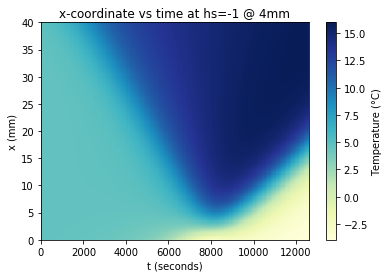

Kappa converged to 0.05


In [353]:
data=pd.read_csv('2021-02-20_battHeater_outside_temp9.0C_IC4.66.csv')
u = pd.DataFrame(data, columns= ['Temperature(℃)']).to_numpy()
t = np.arange(0,u.size*60,60).reshape((u.size, 1))
x= np.linspace(0, 40, num=200)
x=x.reshape((x.size,1))

X, T = np.meshgrid(x, t)

X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))
u_star = u.T.flatten()[:, None]

pred = model(Tensor(X_star).cuda())
pred = pred.detach().cpu().numpy()
H_pred = pred.reshape(X.shape)
plt.imshow(H_pred.T, interpolation='nearest', cmap='YlGnBu',
              extent= [lb[1], ub[1], lb[0], ub[0]],
              origin='lower', aspect='auto')

plt.colorbar().set_label('Temperature (°C)')
plt.title('x-coordinate vs time at hs=-1 @ 4mm')
plt.ylabel('x (mm)')
plt.xlabel('t (seconds)')
plt.show()
print("Kappa converged to %.2f" % (pinn.pde_loss.hpm_model.kappa.item()))
#print('Pred u value at x=1:', (H_pred.T[0,:].flatten()[:, None]))
#print('Exact u value at x=1',u.flatten()[:, None])

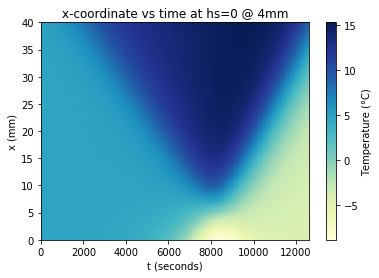

Kappa converged to 0.5


In [344]:
data=pd.read_csv('2021-02-20_battHeater_outside_temp9.0C_IC4.66.csv')
u = pd.DataFrame(data, columns= ['Temperature(℃)']).to_numpy()
t = np.arange(0,u.size*60,60).reshape((u.size, 1))
x= np.linspace(0, 40, num=200)
x=x.reshape((x.size,1))

X, T = np.meshgrid(x, t)

X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))
u_star = u.T.flatten()[:, None]

pred = model(Tensor(X_star).cuda())
pred = pred.detach().cpu().numpy()
H_pred = pred.reshape(X.shape)
plt.imshow(H_pred.T, interpolation='nearest', cmap='YlGnBu',
              extent= [lb[1], ub[1], lb[0], ub[0]],
              origin='lower', aspect='auto')

plt.colorbar().set_label('Temperature (°C)')
plt.title('x-coordinate vs time at hs=0 @ 4mm')
plt.ylabel('x (mm)')
plt.xlabel('t (seconds)')
plt.show()
print("Kappa converged to %.1f" % (pinn.pde_loss.hpm_model.kappa.item()))
#print('Pred u value at x=1:', (H_pred.T[0,:].flatten()[:, None]))
#print('Exact u value at x=1',u.flatten()[:, None])

This plot is showing the temperature distribution at the inner-most point of the battery. Orange is the measured temperature while blue is the estimated temperature of the Physics-informed Neural Network.

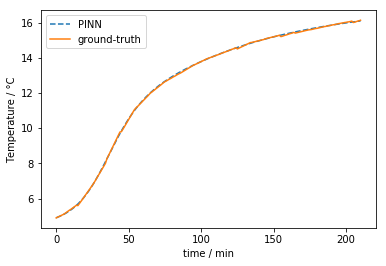

In [335]:
plt.plot(t/60., H_pred[:,-1], '--')
plt.plot(t/60., u, '-')
plt.legend(['PINN', 'ground-truth'])
plt.xlabel('time / min')
plt.ylabel('Temperature / °C')
plt.show()

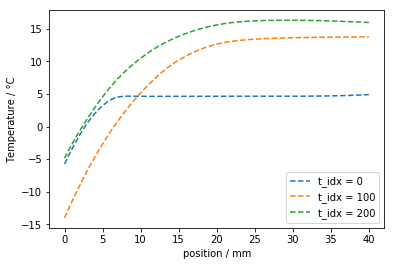

In [336]:
plt.plot(x, H_pred[0,:], '--')
plt.plot(x, H_pred[100,:], '--')
plt.plot(x, H_pred[200,:], '--')
plt.legend(['t_idx = 0','t_idx = 100', 't_idx = 200'])
plt.xlabel('position / mm')
plt.ylabel('Temperature / °C')
plt.show()